In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
import warnings
import argparse
import random
import json
import os
import 
model_path = "/home/sjx/kv/pre_trained_models/Llama-3.1-8B-Instruct"
device = torch.device(f"cuda:7")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
        model_path, torch_dtype=torch.float16,
        attn_implementation="flash_attention_2"
    ).to(device)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
model = model.eval()
datasetmaxlen = 128
dataset2prompt = json.load(open("/home/sjx/papers/cakekv/experiments/LongBench/config/dataset2prompt.json", "r"))
data = load_dataset('THUDM/LongBench', 'qasper', split='test')
data_shuffled = data.shuffle(seed=42)
data_all = data_shuffled.select(range(20))
prompt_format = dataset2prompt['qasper']
max_length = 127500

Using the latest cached version of the module from /home/sjx/.cache/huggingface/modules/datasets_modules/datasets/THUDM--LongBench/4a916a4bde5c3481ac49b84d5dde69a9d2eefcd67f884ef65b3d97ee7cc91f3e (last modified on Mon Dec  2 16:42:37 2024) since it couldn't be found locally at THUDM/LongBench, or remotely on the Hugging Face Hub.


In [3]:
def process_one(data):
    prompt = prompt_format.format(**data)
    tokenized_prompt = tokenizer(prompt, truncation=False, return_tensors="pt").input_ids[0]
    if len(tokenized_prompt) > max_length:
        half = int(max_length/2)
        prompt = tokenizer.decode(tokenized_prompt[:half], skip_special_tokens=True)+tokenizer.decode(tokenized_prompt[-half:], skip_special_tokens=True)
    input = tokenizer(prompt, truncation=False, return_tensors="pt").to(device)
    context_length = input.input_ids.shape[-1]
    print(context_length)
    gen_kwargs = {"do_sample": True, "top_k": 1, "return_dict_in_generate": True}
    outputs = model.generate(
            **input,
            **gen_kwargs,
            max_new_tokens=1
        )
    past_key_values = outputs['past_key_values']
    return past_key_values

In [4]:
past_key_values = process_one(data_all[0])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


3302


In [8]:
def calculate_sparse_v(past_key_values):
    results = []
    num_layers = len(past_key_values)
    for layer in range(num_layers):
        key = past_key_values[layer][1].squeeze(0)
        pca_n_components = 2
        seq_len = key.shape[1]
        key = key.permute(1,0,2).reshape(seq_len, -1)
        pca = PCA(n_components=pca_n_components)
        value_2d = pca.fit_transform(key.cpu().numpy())
        explained_variance = pca.explained_variance_
        dispersion_score = explained_variance.sum()
        results.append(dispersion_score)
    return results

In [11]:
score = sparse_k + sparse_v

In [15]:
import matplotlib.pyplot as plt;

def vis_score(score_list):
    plt.plot(score_list, marker='o')
    plt.title('Line Plot of List')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [18]:
coeffs = np.load('/home/sjx/papers/cakekv/experiments/LongBench/full_fit_llama3_combined15_pca4.npy')

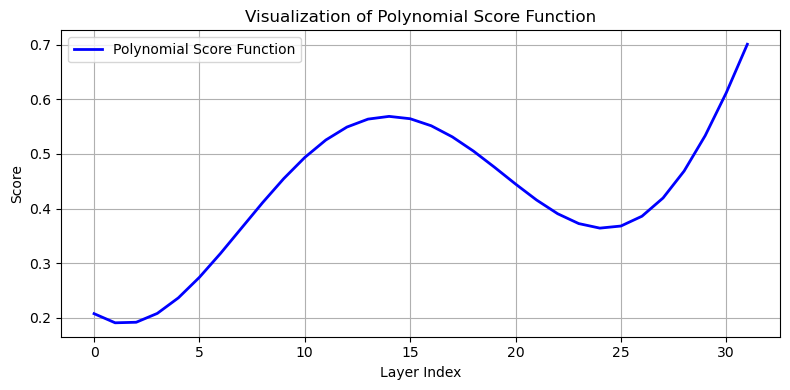

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# 创建多项式得分函数
score_func = Polynomial(coeffs)

# 定义 x 范围（比如 32 层）
x = np.arange(32)
y = score_func(x)

# 可视化
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Polynomial Score Function', color='blue', linewidth=2)
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.title("Visualization of Polynomial Score Function")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def analyze_and_plot_layer(key_tensor: torch.Tensor, layer_idx: int, dispersion_score: float, title_prefix: str, compress_ratio=0.5):
    """
    对给定的单层Key张量进行压缩、分析和可视化。
    (已更新) 本函数现在可以处理 [batch, num_heads, seq_len, head_dim] 的输入。
    """
    print(f"\n--- 正在分析 {title_prefix} (第 {layer_idx} 层) ---")

    if key_tensor.dim() != 4:
        raise ValueError(f"期望的输入维度为4, 但收到了 {key_tensor.dim()}")

    # a. 预处理并获取完整表示
    # 将 [1, num_heads, seq_len, head_dim] -> [seq_len, num_heads * head_dim]
    key_tensor_squeezed = key_tensor.squeeze(0)
    seq_len = key_tensor_squeezed.shape[1]
    K_full = key_tensor_squeezed.permute(1, 0, 2).reshape(seq_len, -1)
    
    print(f"输入形状: {key_tensor.shape} -> 处理后形状进行分析: {K_full.shape}")
    
    # 确保在CPU上进行计算
    K_full = K_full.cpu()
    
    # b. 施加均匀压缩
    num_to_keep = int(seq_len * (1 - compress_ratio))
    
    # 创建随机索引并分割
    shuffled_indices = torch.randperm(seq_len)
    kept_indices = shuffled_indices[:num_to_keep]
    evicted_indices = shuffled_indices[num_to_keep:]
    
    K_compressed = K_full[kept_indices, :]
    
    print(f"原始序列长度: {seq_len}, 压缩后保留: {num_to_keep}")

    # c. 计算均值向量 (类似于KEYDIFF论文中的'anchor vector')
    mu_full = K_full.mean(dim=0)
    mu_compressed = K_compressed.mean(dim=0)

    # d. 计算并打印表示失真度
    distortion_score = torch.linalg.norm(mu_full - mu_compressed).item()
    print(f"表示失真度 (L2 Norm): {distortion_score:.4f}")

    # e. PCA降维用于可视化
    pca = PCA(n_components=2)
    # 使用完整的Key Cache来拟合PCA，以获得一个统一的坐标系
    K_full_2d = pca.fit_transform(K_full.numpy().astype(np.float32))

    # f. 绘图
    plt.figure(figsize=(10, 8))
    
    # 绘制被丢弃的点 (Evicted)
    plt.scatter(
        K_full_2d[evicted_indices, 0], 
        K_full_2d[evicted_indices, 1], 
        c='orange', 
        alpha=0.4, 
        label=f'Evicted Tokens'
    )
    
    # 绘制被保留的点 (Retained)
    plt.scatter(
        K_full_2d[kept_indices, 0], 
        K_full_2d[kept_indices, 1], 
        c='blue', 
        alpha=0.6, 
        label=f'Retained Tokens'
    )
    
    # 转换均值向量到2D空间
    mu_full_2d = pca.transform(mu_full.numpy().reshape(1, -1))
    mu_compressed_2d = pca.transform(mu_compressed.numpy().reshape(1, -1))
    
    # 绘制均值向量
    plt.scatter(
        mu_full_2d[:, 0], 
        mu_full_2d[:, 1], 
        c='black', 
        marker='*', 
        s=400, 
        edgecolors='white',
        label='Origin AVG (μ_full)'
    )
    plt.scatter(
        mu_compressed_2d[:, 0], 
        mu_compressed_2d[:, 1], 
        c='red', 
        marker='*', 
        s=400, 
        edgecolors='white',
        label=f'Compressed AVG (μ_compressed)'
    )
    
    plt.title(f"{title_prefix}:  {layer_idx} Dispersioin_Score {dispersion_score:.4f} | L2 Norm: {distortion_score:.4f}", fontsize=16)
    plt.xlabel("(Principal Component 1)")
    plt.ylabel("(Principal Component 2)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [29]:
score = []
for i in range(32):
    score.append(score_func(i))

In [30]:
score

[0.20790287421186138,
 0.1911924142453218,
 0.19218145507836365,
 0.20835100711977605,
 0.23680767075887538,
 0.274444923239322,
 0.31808875915541823,
 0.36462768457088696,
 0.4111270647601317,
 0.4549278255719773,
 0.4937295084158921,
 0.5256576788706908,
 0.549315688915719,
 0.5638207927845169,
 0.568824616440968,
 0.564517980677923,
 0.5516200778383109,
 0.5313520021587268,
 0.5053946337355023,
 0.4758308761132584,
 0.44507224749593455,
 0.4157698255803056,
 0.3907095460119752,
 0.37269185446385167,
 0.3643957123370971,
 0.36822695608458783,
 0.38615101015679604,
 0.4195099535702324,
 0.46882394009828315,
 0.533576972084614,
 0.6119870278789794,
 0.7007605428955707]

In [32]:
low_disp_layer_idx = np.argmin(np.array(score))

In [33]:
low_disp_layer_idx

1


--- 正在分析 High (High-Dispersion Layer) (第 2 层) ---
输入形状: torch.Size([1, 8, 3302, 128]) -> 处理后形状进行分析: torch.Size([3302, 1024])
原始序列长度: 3302, 压缩后保留: 330
表示失真度 (L2 Norm): 2.5117


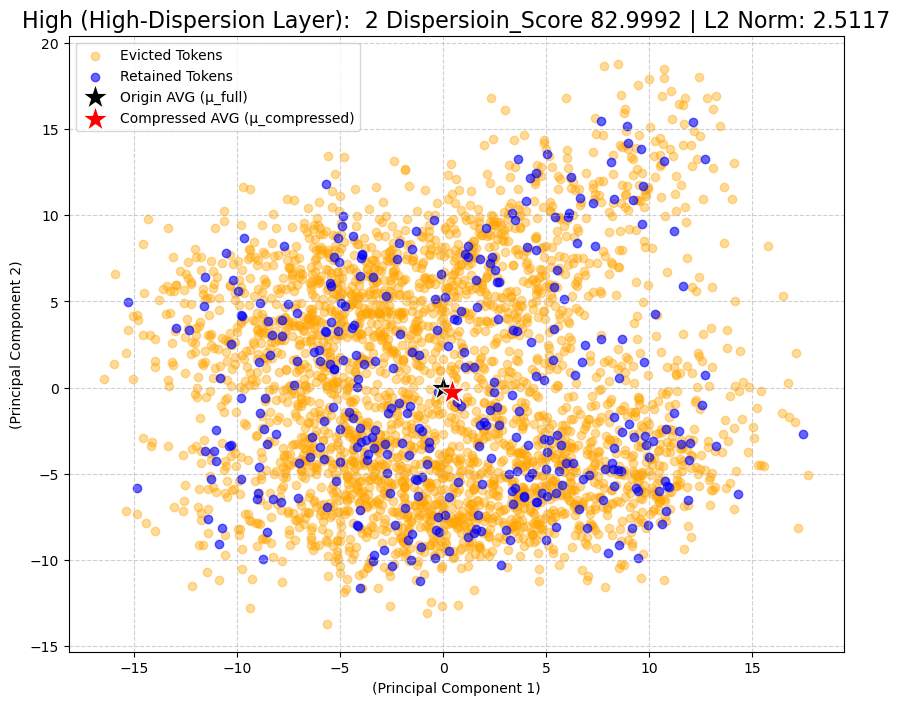

In [200]:
analyze_and_plot_layer(
    key_tensor=past_key_values[2][0],
    layer_idx=2,
    dispersion_score=dispersion_scores[2],
    title_prefix="High (High-Dispersion Layer)",
    compress_ratio=0.9
)


--- 正在分析 High (High-Dispersion Layer) (第 12 层) ---
输入形状: torch.Size([1, 8, 3302, 128]) -> 处理后形状进行分析: torch.Size([3302, 1024])
原始序列长度: 3302, 压缩后保留: 1651
表示失真度 (L2 Norm): 0.8457


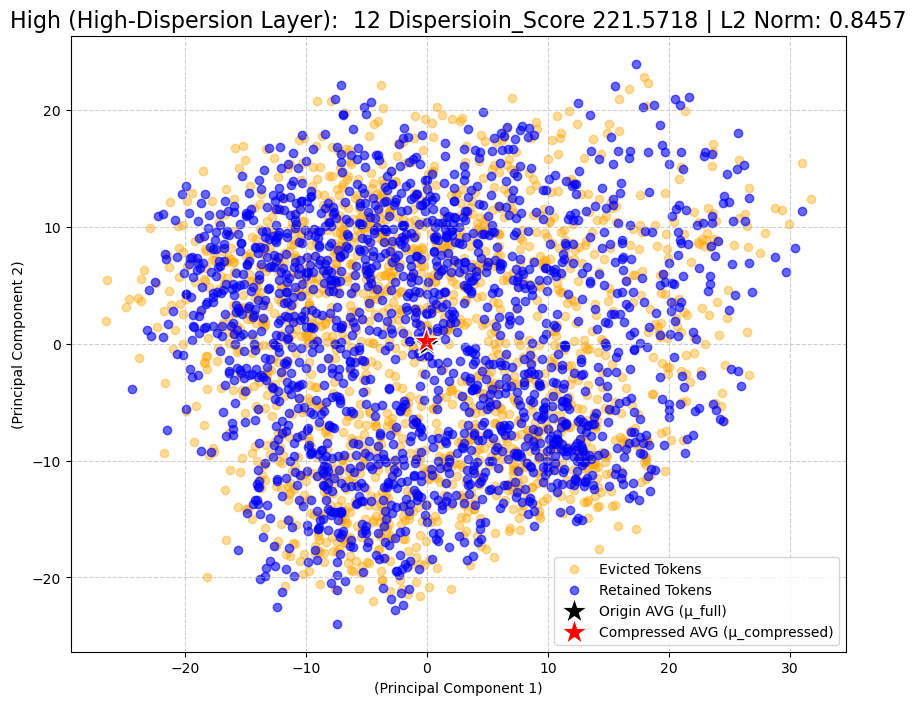

In [58]:
analyze_and_plot_layer(
    key_tensor=past_key_values[12][0],
    layer_idx=12,
    dispersion_score=dispersion_scores[12],
    title_prefix="High (High-Dispersion Layer)"
)


--- 正在分析 低离散度层 (Low-Dispersion Layer) (第 0 层) ---
输入形状: torch.Size([1, 8, 3302, 128]) -> 处理后形状进行分析: torch.Size([3302, 1024])
原始序列长度: 3302, 压缩后保留: 1651
表示失真度 (L2 Norm): 0.0184


/home/sjx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  

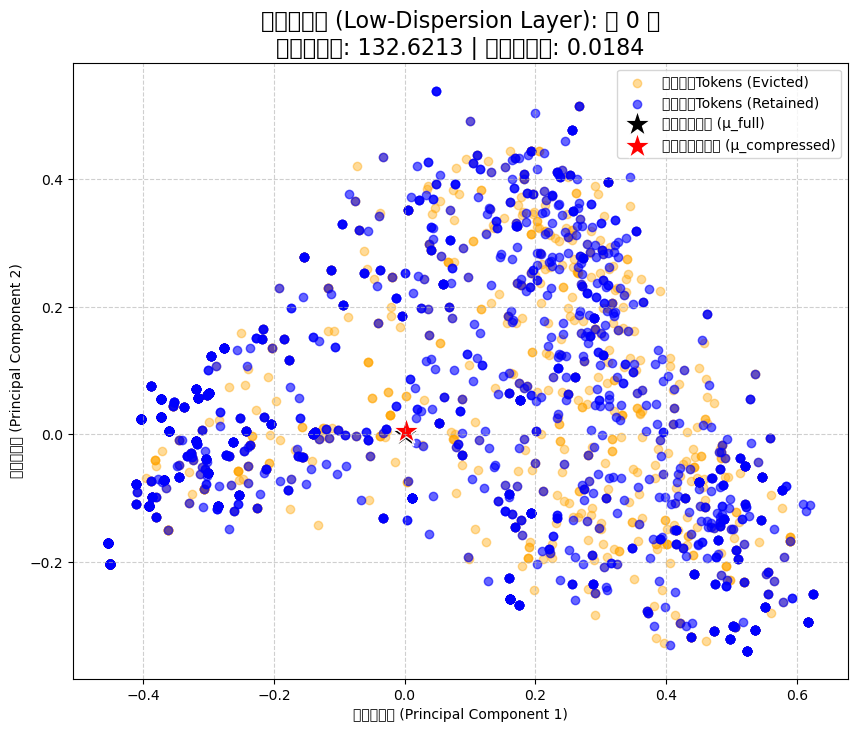

In [47]:
analyze_and_plot_layer(
    key_tensor=past_key_values[0][1],
    layer_idx=0,
    dispersion_score=dispersion_scores[0],
    title_prefix="低离散度层 (Low-Dispersion Layer)"
)

In [28]:
key_tensor = past_key_values[13][0]

In [29]:
key_tensor.shape

torch.Size([1, 8, 3302, 128])

In [34]:
test = torch.load('/data/sjx/score/kv_cache/llama3.1-8b-128k/cache_2wikimqa.pt')